import necessary packages

In [1]:
from MIR.models import SpatialTransformer, AffineReg3D
import nibabel as nib
from scipy.ndimage import zoom
import numpy as np
import torch
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


read in images

In [2]:
img_nib = nib.load('sub-01_T1w.nii.gz')
template_nib = nib.load('LUMIR_template.nii.gz')
original_affine = img_nib.affine.copy()
original_shape = img_nib.shape
original_pixdim = img_nib.header.structarr['pixdim'][1:-4]

reorient and resample the image if needed

In [3]:
def reorient_image_to_match(reference_nii, target_nii):
    reference_ornt = nib.aff2axcodes(reference_nii.affine)
    target_reoriented = nib.as_closest_canonical(target_nii, enforce_diag=False)
    target_ornt = nib.aff2axcodes(target_reoriented.affine)
    
    # If orientations don't match, perform reorientation
    if target_ornt != reference_ornt:
        # Calculate the transformation matrix to match the reference orientation
        ornt_trans = nib.orientations.ornt_transform(nib.io_orientation(target_reoriented.affine),
                                                     nib.io_orientation(reference_nii.affine))
        target_reoriented = target_reoriented.as_reoriented(ornt_trans)
    return target_reoriented

def resampling(img_npy, img_pixdim, tar_pixdim, order, mode='constant'):
    if order == 0:
        img_npy = img_npy.astype(np.uint16)
    img_npy = zoom(img_npy, ((img_pixdim[0] / tar_pixdim[0]), (img_pixdim[1] / tar_pixdim[1]), (img_pixdim[2] / tar_pixdim[2])), order=order, prefilter=False, mode=mode)
    return img_npy

img_nib = reorient_image_to_match(template_nib, img_nib)
affine_type = 'Affine'
affine_metric = 'meanSquares'
tar_pixdim = [1.0, 1.0, 1.0]  # Target pixel dimensions
img_pixdim = img_nib.header.structarr['pixdim'][1:-4]

img_npy = img_nib.get_fdata()
img_npy = resampling(img_npy, img_pixdim, tar_pixdim, order=2)
img_torch = torch.from_numpy(img_npy[np.newaxis, np.newaxis, ...]).float().cuda(0)
template_npy = template_nib.get_fdata()
template_torch = torch.from_numpy(template_npy[np.newaxis, np.newaxis, ...]).float().cuda(0)

affine registration

[AffineReg3D] scale 1/2 step 1/50 loss=0.044751
[AffineReg3D] scale 1/2 step 10/50 loss=0.032137
[AffineReg3D] scale 1/2 step 20/50 loss=0.031100
[AffineReg3D] scale 1/2 step 30/50 loss=0.017071
[AffineReg3D] scale 1/2 step 40/50 loss=0.015254
[AffineReg3D] scale 1/2 step 50/50 loss=0.013789
[AffineReg3D] scale 2/2 step 1/50 loss=0.028520
[AffineReg3D] scale 2/2 step 10/50 loss=0.018542
[AffineReg3D] scale 2/2 step 20/50 loss=0.017596
[AffineReg3D] scale 2/2 step 30/50 loss=0.017356
[AffineReg3D] scale 2/2 step 40/50 loss=0.017342
[AffineReg3D] scale 2/2 step 50/50 loss=0.017337


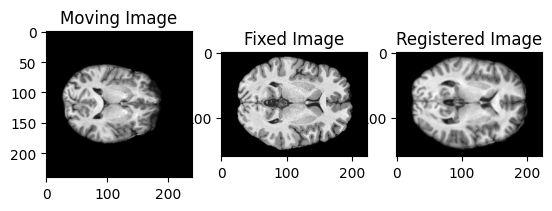

In [4]:
spatial_trans = SpatialTransformer(size=template_torch.shape[2:], mode='bilinear').cuda(0)
affine_model = AffineReg3D(vol_shape=template_torch.shape[2:], dof = "affine", scales = (0.5, 1.0), loss_funcs = ("mse", "mse"), ).cuda(0)
output = affine_model.optimize(img_torch, template_torch, steps_per_scale=(50, 50), verbose=True)['warped']
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(img_torch[0, 0, :, :, img_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Moving Image')
plt.subplot(1, 3, 2)
plt.imshow(template_torch[0, 0, :, :, template_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Fixed Image')
plt.subplot(1, 3, 3)
plt.imshow(output[0, 0, :, :, output.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Registered Image')
plt.show()

rigid registration

[AffineReg3D] scale 1/2 step 1/50 loss=0.044751
[AffineReg3D] scale 1/2 step 10/50 loss=0.040703
[AffineReg3D] scale 1/2 step 20/50 loss=0.031275
[AffineReg3D] scale 1/2 step 30/50 loss=0.031073
[AffineReg3D] scale 1/2 step 40/50 loss=0.030879
[AffineReg3D] scale 1/2 step 50/50 loss=0.030839
[AffineReg3D] scale 2/2 step 1/50 loss=0.037222
[AffineReg3D] scale 2/2 step 10/50 loss=0.033247
[AffineReg3D] scale 2/2 step 20/50 loss=0.033222
[AffineReg3D] scale 2/2 step 30/50 loss=0.033222
[AffineReg3D] scale 2/2 step 40/50 loss=0.033222
[AffineReg3D] scale 2/2 step 50/50 loss=0.033222


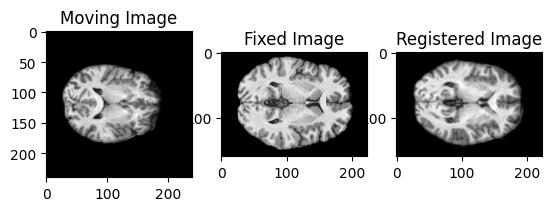

In [5]:
spatial_trans = SpatialTransformer(size=template_torch.shape[2:], mode='bilinear').cuda(0)
affine_model = AffineReg3D(vol_shape=template_torch.shape[2:], dof = "rigid", scales = (0.5, 1.0), loss_funcs = ("mse", "mse"), ).cuda(0)
output = affine_model.optimize(img_torch, template_torch, steps_per_scale=(50, 50), verbose=True)['warped']
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(img_torch[0, 0, :, :, img_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Moving Image')
plt.subplot(1, 3, 2)
plt.imshow(template_torch[0, 0, :, :, template_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Fixed Image')
plt.subplot(1, 3, 3)
plt.imshow(output[0, 0, :, :, output.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Registered Image')
plt.show()

translation only registration

[AffineReg3D] scale 1/2 step 1/50 loss=0.044751
[AffineReg3D] scale 1/2 step 10/50 loss=0.035757
[AffineReg3D] scale 1/2 step 20/50 loss=0.035602
[AffineReg3D] scale 1/2 step 30/50 loss=0.035602
[AffineReg3D] scale 1/2 step 40/50 loss=0.035602
[AffineReg3D] scale 1/2 step 50/50 loss=0.035602
[AffineReg3D] scale 2/2 step 1/50 loss=0.041275
[AffineReg3D] scale 2/2 step 10/50 loss=0.038631
[AffineReg3D] scale 2/2 step 20/50 loss=0.038604
[AffineReg3D] scale 2/2 step 30/50 loss=0.038604
[AffineReg3D] scale 2/2 step 40/50 loss=0.038604
[AffineReg3D] scale 2/2 step 50/50 loss=0.038604


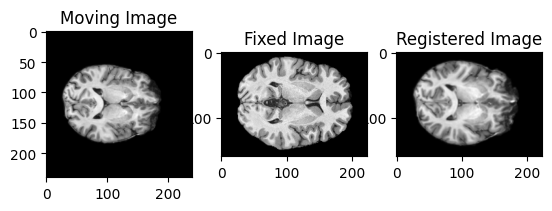

In [6]:
spatial_trans = SpatialTransformer(size=template_torch.shape[2:], mode='bilinear').cuda(0)
affine_model = AffineReg3D(vol_shape=template_torch.shape[2:], dof = "translation", scales = (0.5, 1.0), loss_funcs = ("mse", "mse"), ).cuda(0)
output = affine_model.optimize(img_torch, template_torch, steps_per_scale=(50, 50), verbose=True)['warped']
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(img_torch[0, 0, :, :, img_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Moving Image')
plt.subplot(1, 3, 2)
plt.imshow(template_torch[0, 0, :, :, template_torch.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Fixed Image')
plt.subplot(1, 3, 3)
plt.imshow(output[0, 0, :, :, output.shape[4] // 2].detach().cpu().numpy(), cmap='gray')
plt.title('Registered Image')
plt.show()